# Purpose: An older version of "Evaluate Model" which used ZScale for normalization rather than the image background

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1]:
from keras.models import load_model
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool
import cupy as cp
from cupyx.scipy.ndimage.filters import convolve
import tensorflow as tf
import innvestigate
import reproject
import astroscrappy
import subprocess
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from keras.backend.tensorflow_backend import set_session

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Using TensorFlow backend.


In [2]:
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

gain = 6.2

amp_factor = 1.5


def gaussian(x, offset, std, amp):
    return amp * np.exp(-np.power(x - offset, 2.) / (2 * np.power(std, 2.)))


def gaussian_streak(width, offset, std, amp, bkg):
    dist = gaussian(np.arange(width), offset, std, amp) + bkg
    return dist


def implant_random_streak(image):

    image = np.copy(image)

    while True:
        std = stats.gamma.rvs(*params_gamma_width) * 0.05
        width = std * 10

        if random.random() < 0.7:
            length = stats.gamma.rvs(*params_gamma_length)
        else:
            length = np.random.random() * 30 + 10

        # use 2*std, which is "real" width
        if length / (std * 2) > 2 and length > 10 and width > 0:
            break

    streak = np.repeat(np.array([gaussian_streak(width, width / 2, std, 1, 0)]).T, length, axis=1)
    rotation = np.random.uniform(0, 360)
    streak = skimage.transform.rotate(streak, rotation, resize=True, order=3)

    y_len, x_len = image.shape
    y_len_streak, x_len_streak = streak.shape
    x_streak = np.random.randint(0, x_len - x_len_streak)
    y_streak = np.random.randint(0, y_len - y_len_streak)

#     print(y_streak, x_streak)
    
    amp_min = np.std(image[y_streak:y_streak + y_len_streak, x_streak:x_streak + x_len_streak]) * amp_factor
#     amp_min = max(np.std(image), np.std(image[y_streak:y_streak + y_len_streak, x_streak:x_streak + x_len_streak])) * amp_factor

    if random.random() < 0.9:
        amplitude = amp_min * (1 + abs(np.random.randn()))
    else:
        amplitude = (np.random.random() * 5) * amp_min

    streak *= amplitude

    # add shot noise
    streak = np.random.poisson(streak * gain)

    streak = streak / gain
    shape = streak.shape
    image[y_streak:y_streak + shape[0], x_streak:x_streak + shape[1]] += streak

    return image, y_streak, x_streak, streak

In [3]:
# model = load_model("/home/fwang/wandb/run-20200419_062135-rljo4afi/model-best_0.0004998333888703765_0.9704852426213106_0.9609805.h5")
# thresh = 0.9609805
model = load_model("/home/fwang/wandb/run-20200519_194207-xixqjezt/model-best_0.0005714285714285715_0.9702380952380952_0.95495033.h5")
thresh = 0.95495033

In [4]:
# align the reference file to the science, returns science and reference
def swarp_align(sci_file, ref_file):
    ref, header = fits.getdata(ref_file, header=True)

    filename_sci = sci_file.split("/")[-1]
    directory = "/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci[:-len(".fits")]
    
    os.makedirs(directory, exist_ok=True)
    with open(directory + "/coadd.head", "w") as f:
        f.write(repr(header) + "\nEND     ")

    subprocess.run(["swarp", sci_file, "-c", "/home/fwang/Pipeline/swarp.conf", "-VERBOSE_TYPE", "QUIET"],
                     cwd=directory, stderr=subprocess.DEVNULL)

    return [fits.getdata(directory + "/coadd.fits"), ref]

In [6]:
sci, ref = swarp_align(filename_pairs[100][0], filename_pairs[100][1])

NameError: name 'filename_pairs' is not defined

In [106]:
sci_crop = sci[1000:1080, 1000:1080]
ref_crop = ref[1000:1080, 1000:1080]

In [115]:
sci_implant, y, x, streak = implant_random_streak(sci_crop)
ref_implant = np.copy(ref_crop)
ref_implant[y:y+streak.shape[0], x:x+streak.shape[1]] += streak

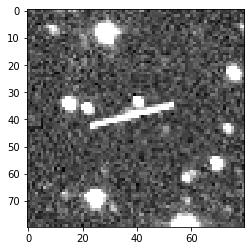

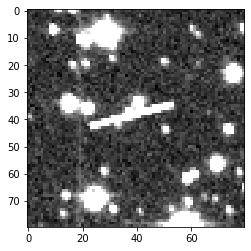

In [125]:
plt.imshow(normalize(sci_implant), cmap="gray")
plt.figure()
plt.imshow(normalize(ref_implant), cmap="gray")

In [146]:
model.predict(np.transpose(np.array([[sci_implant, ref_implant]]), (0, 2, 3, 1)))

array([[0.9998301]], dtype=float32)

In [132]:
ref_implant[~np.isfinite(ref_implant)] = 0

In [133]:
sci, ref = normalize_cuda(cp.array([sci_implant, ref_implant], dtype=cp.float32)).get()

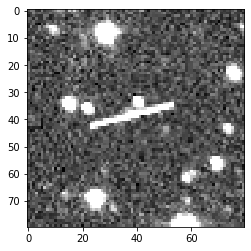

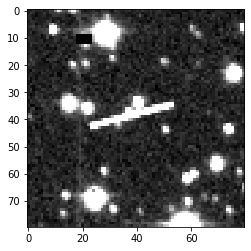

In [134]:
plt.imshow(sci, cmap="gray")
plt.figure()
plt.imshow(ref, cmap="gray")

In [5]:
contrast = 0.35
size = 80

def linear_regression(x, y, w):
    B = cp.matmul(x.T, cp.expand_dims(cp.multiply(w, y), -1))
    B2 = cp.linalg.inv(cp.matmul(x.T, cp.multiply(cp.expand_dims(w, -1), x)))
    return cp.matmul(B2, B)[..., 0]


def weighted_std(values, weights):
    average = cp.expand_dims(cp.average(values, weights=weights, axis=-1), -1)
    # Fast and numerically precise:
    variance = cp.average((values - average) ** 2, weights=weights, axis=-1)
    return cp.sqrt(variance)


# for some reason CuPy just doesn't have median function
def get_median(arr):
    size = arr.shape[-1]
    return (arr[:, size // 2] + arr[:, size // 2 + 1]) / 2


def normalize_cuda(arr, nsamples=size * size // 8):

    values = cp.reshape(arr, (len(arr), size * size))
    stride = (size * size) // nsamples

    samples = cp.array(values[::, ::stride][::, :nsamples])
    samples.sort()

    npix = nsamples
    nimage = len(arr)

    x = cp.arange(npix)
    x_fit = cp.stack((x, cp.ones(x.shape)), axis=-1)

    # pixels mask used in k-sigma clipping
    goodpix = cp.ones((nimage, npix))

    ngrow = max(1, int(npix * 0.01))
    kernel = cp.ones((1, ngrow))

    for niter in range(3):
        fit = linear_regression(x_fit, samples, goodpix)
        slope = fit[:, 0]
        intercept = fit[:, 1]

        fitted = cp.expand_dims(slope, 1) * cp.expand_dims(x, 0) + cp.expand_dims(intercept, 1)

        # Subtract fitted line from the data array
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        threshold = cp.expand_dims(2.5 * weighted_std(flat, goodpix), -1)

        # Detect and reject pixels further than k*sigma from the
        # fitted line
        goodpix[(flat < - threshold) | (flat > threshold)] = 0

        goodpix = 1 - cp.clip(convolve(1 - goodpix, kernel), 0, 1)

    if contrast > 0:
        slope = slope / contrast
    center_pixel = (npix - 1) // 2
    median = get_median(samples)

    vmin = median - (center_pixel - 1) * slope
    vmax = median + (npix - center_pixel) * slope

    old_min = cp.min(samples, axis=1)
    old_max = cp.max(samples, axis=1)

    vmin = cp.maximum(vmin, old_min)
    vmax = cp.minimum(vmax, old_max)

    vmin = cp.reshape(vmin, (len(arr), 1, 1))
    vmax = cp.reshape(vmax, (len(arr), 1, 1))

    arr -= vmin
    arr /= vmax - vmin

    arr = cp.clip(arr, 0, 1)


    # # CuPy operations on multiple axes doesn't seem to be working
    # mean = cp.mean(cp.mean(arr, axis=1, keepdims=True), axis=2, keepdims=True)
    #
    # # CuPy operations on multiple axes doesn't seem to be working
    # std = cp.std(cp.std(arr, axis=1, keepdims=True), axis=2, keepdims=True)

    arr = (arr - cp.mean(arr, axis=(1, 2), keepdims=True)) / cp.std(arr, axis=(1, 2), keepdims=True)

    return arr


def normalize(arr, samples=size * size // 4):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)

    
    return (arr - 0.5) * 2

In [44]:
# nums represent FPR, TPR, threshold
model = load_model("/home/fwang/wandb/run-20200419_062135-rljo4afi/model-best_0.001833944648216072_0.9730134932533733_0.5842777.h5")
# FPR = 0.001037037, TPR = 0.974388889
# model = load_model("/home/fwang/wandb/run-20200418_020552-8c1w6m3j/model-best.h5")
# model = load_model("/home/fwang/wandb/run-20200416_065139-jeryxmyo/model-best.h5")
# MODEL FOR NORMALIZATION WITH ZSCALE
# model = load_model("/home/fwang/wandb/run-20200208_034755-ve68xd4n/model-best.h5")
# MODEL FOR OLDER GPU ACCELERATED NORMALIZATION THAT WAS NOT ACCURATE
# model = load_model("/home/fwang/wandb/run-20200224_230632-sx0eb942/model-best.h5")

In [7]:
def convert_sci_to_ref(file):
    info = file.split("_")[2:-1]
    return "/media/rd1/ztf_neos/pipeline/reference/ztf_" + "_".join(info[1:4] + info[5:6]) + "_refimg.fits"

In [8]:
filenames = glob.glob("/media/rd1/ztf_neos/pipeline/science/*.fits")
filename_pairs = [(file, convert_sci_to_ref(file)) for file in filenames]

In [9]:
def convert_sci_to_ref2(file):
    filename = file.split("/")[-1]
    return "/media/rd1/ztf_neos/fits_files_reference/" + filename[:-len("sciimg.fits")] + "refimg.fits"

In [10]:
real_filenames = glob.glob("/media/rd1/ztf_neos/fits_files_science/*")
real_filename_pairs = [(file, convert_sci_to_ref2(file)) for file in real_filenames]

In [11]:
# align the reference file to the science, returns science and reference
def swarp_align(sci_file, ref_file):
    header = fits.getheader(ref_file)
    
#     filename_sci = sci_file.split("/")[-1]
    
    with open("/home/fwang/Pipeline/coadd.head", "w") as f:
        f.write(repr(header) + "\nEND     ")
        
    val = subprocess.run(["swarp", sci_file, "-c", "/home/fwang/Pipeline/swarp.conf"], cwd="/home/fwang/Pipeline") #, stderr=subprocess.PIPE, universal_newlines=True)

    return [fits.getdata("/home/fwang/Pipeline/coadd.fits"),
            fits.getdata(ref_file)]

#     print(str(val.stderr))
    
#     print("/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci)
#     return [fits.getdata("/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci),
#             fits.getdata(ref_file)]


# , "-IMAGEOUT_NAME", "/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci
# , "-IMAGEOUT_NAME", filename_sci
# /media/rd1/ztf_neos/pipeline/resampled/

In [11]:
def distance(c1, c2):
    return ((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2) ** 0.5


def check_images(images):
    works = []
    thresholds = [1.0, 1.3, 1.5, 2.0]
    for image, _ in images:
        if image.size == 0:
            works.append(False)
            continue

        bkg = sep.Background(np.array(image))
        image = image - bkg

        did_work = False
        for threshold in thresholds:

            threshold = bkg.rms() * threshold
        #     threshold = detect_threshold(image, 1.5)
        #     threshold = skimage.filters.thresholding.threshold_(image)

            segm = detect_sources(image, threshold, 20, connectivity=4)

            try:
                segm = deblend_sources(image, segm, 20, connectivity=4)
            except:
                break

            info = source_properties(image, segm)

            best_streak = None

            for obj in info:
                cutout = obj.data_cutout_ma
                elongation = obj.elongation
                bbox = [obj.bbox.ixmin, obj.bbox.ixmax, obj.bbox.iymin, obj.bbox.iymax]
                bbox = np.array(bbox, np.float64)
                length = distance(cutout.shape, (0,0))
                if length > 5 and elongation > 2:
                    did_work = True
                    break

            if did_work:
                break
        works.append(did_work)

    return images[works]


def process_images(sci_file, ref_file, threshold=0.5, batch_size=2048):

    
    sci, ref = swarp_align(sci_file, ref_file)
    

    
    y_len, x_len = sci.shape
    images = []
    bounds = []
    for i in range(0, y_len, 50):
        for j in range(0, x_len, 50):
            if j + size >= x_len or i + size >= y_len:
                continue

            crop_sci = sci[i:i+80, j:j+80]
            crop_ref = ref[i:i+80, j:j+80]

            if np.sum(np.abs(crop_sci) == 0) >= 10 or np.sum(np.abs(crop_ref) == 0) >= 10 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
                continue

            images.append([crop_sci, crop_ref])
            bounds.append([[j,j+80],[i,i+80]])

    
    images = np.array(images)
    
    images_gpu = cp.array(images, dtype=cp.float64)
    images_gpu = cp.reshape(images_gpu, (-1, 80, 80))
    

    norm_images = normalize_cuda(images_gpu, size * size // 8)

    norm_images = cp.reshape(norm_images, (-1, 2, size, size)).get()
    
    norm_images_transpose = np.transpose(norm_images, [0, 2, 3, 1])

    
    preds = model.predict(norm_images_transpose, batch_size=batch_size)[:, 0]

    
    indexes = preds > threshold
    
    top_images = images[indexes]
#     print(top_images)
#     plt.imshow(normalize(top_images[0][0]), cmap="gray")
#     plt.figure()
#     plt.imshow(normalize(top_images[0][1]), cmap="gray")

    top_images = check_images(top_images)


#     print(np.sort(preds))
#     print(top_images)
    
#     plt.imshow(norm_images[np.argsort(preds)[::-1][0]][0], cmap="gray")
#     plt.figure()
#     plt.imshow(norm_images[np.argsort(preds)[::-1][0]][1], cmap="gray")
#     plt.figure()
    
#     plt.imshow(norm_images[np.argsort(preds)[::-1][1]][0], cmap="gray")
#     plt.figure()
#     plt.imshow(norm_images[np.argsort(preds)[::-1][1]][1], cmap="gray")
    

    if len(top_images) > 0:
    
        remove_cosmics = []

        for sci, ref in top_images:
            remove_cosmics.append([astroscrappy.detect_cosmics(sci)[1], ref])
        
        images_gpu = cp.array(remove_cosmics, dtype=cp.float64)
        images_gpu = cp.reshape(images_gpu, (-1, 80, 80))

        norm_images = normalize_cuda(images_gpu, size * size // 8)
        norm_images = cp.reshape(norm_images, (-1, 2, size, size)).get()

        norm_images_transpose = np.transpose(norm_images, [0, 2, 3, 1])


        preds = model.predict(norm_images_transpose, batch_size=batch_size)[:, 0]

        indexes = preds > threshold
        
        return top_images[indexes], norm_images[indexes], preds[indexes]

    return [], [], []

Done
Done
Done
Done
Done
Done
Done
Done
Done
[1.9073486e-06 2.1457672e-06 2.3543835e-06 ... 9.9435484e-01 9.9756849e-01
 9.9874699e-01]
Done
Done
CPU times: user 3.7 s, sys: 28.6 s, total: 32.3 s
Wall time: 36 s


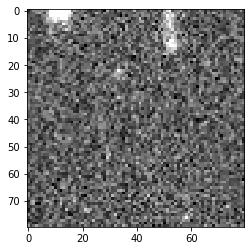

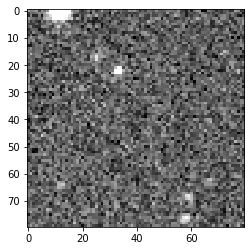

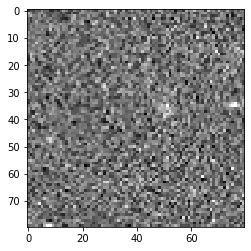

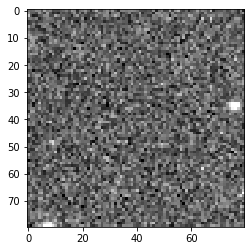

In [84]:
%%time
i = 9000
images, norm_images, preds = process_images(*real_filename_pairs[i], thresh, 128)

In [62]:
%%time
i = 57
images, norm_images, preds = process_images(*filename_pairs[i], thresh, 64)

CPU times: user 4.34 s, sys: 40.5 s, total: 44.9 s
Wall time: 49.2 s


0.9990596


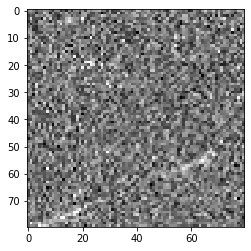

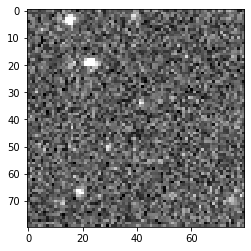

In [74]:
i = 10
print(preds[i])
plt.imshow(norm_images[i][0], cmap="gray")
plt.figure()
plt.imshow(norm_images[i][1], cmap="gray")

In [28]:
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a", model)

In [29]:
image = np.transpose(norm_images[i], [1, 2, 0])

In [30]:
result = analyzer.analyze(np.array([image]))

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [125]:
%%time
pairs = []

print(len(real_filename_pairs))

total = 0

for i, (sci_file, ref_file) in enumerate(real_filename_pairs):
    try:
        images = process_images(sci_file, ref_file)
        pairs.append(images)
        total += len(images)
        print(i)
        print(total)
    except:
        print(sci_file)
        print(ref_file)

475
[0.         0.         0.         ... 0.09362075 0.13635823 0.23030615]
0
0
[0.         0.         0.         ... 0.56836903 0.6092951  0.6487655 ]
1
0
[0.         0.         0.         ... 0.7417749  0.77807516 0.91306627]
2
0
[0.         0.         0.         ... 0.98634404 0.98844683 0.99499583]
3
2
[0.         0.         0.         ... 0.89519703 0.8955172  0.9999465 ]
4
3
[0.         0.         0.         ... 0.93315065 0.97060406 0.99234265]
5
4
[0.         0.         0.         ... 0.572821   0.60947657 0.9736254 ]
6
4
[0.        0.        0.        ... 0.9997105 0.9999813 0.9999885]
7
8
[0.         0.         0.         ... 0.15936172 0.30781072 0.9996386 ]
8
8
[0.        0.        0.        ... 0.9982034 0.9986765 1.       ]
9
12
[0.         0.         0.         ... 0.9451087  0.98679507 0.9999317 ]
10
14
[0.         0.         0.         ... 0.80669487 0.81135416 0.98506343]
11
14
[0.         0.         0.         ... 0.9608057  0.9886415  0.99477696]
12
16
[0.         0

[0.        0.        0.        ... 0.8324833 0.9663366 0.9992495]
23
22


[0.         0.         0.         ... 0.9998652  0.99987936 0.9999809 ]
49
83
[0.         0.         0.         ... 0.27882403 0.36031467 0.5401871 ]
50
83
[0.         0.         0.         ... 0.99011624 0.99312997 0.9999808 ]
51
86
[0.         0.         0.         ... 0.9803268  0.98458904 0.99999195]
52
88
[0.         0.         0.         ... 0.21635604 0.30863482 0.32579532]
53
88
[0.         0.         0.         ... 0.9999988  0.99999917 1.        ]
54
90
[0.         0.         0.         ... 0.9542537  0.99671966 0.9998846 ]
55
92
[0.         0.         0.         ... 0.98669124 0.99999976 1.        ]
56
96
[0.         0.         0.         ... 0.99363714 1.         1.        ]
57
100
[0.         0.         0.         ... 0.96916085 0.9771532  0.9957155 ]
58
100
[0.         0.         0.         ... 0.9999931  0.9999932  0.99999833]
59
100
[0.         0.         0.         ... 0.62001956 0.68207234 0.75549424]
60
100
[0.        0.        0.        ... 0.9246572 0.9975089 0.999

[0.        0.        0.        ... 0.9947901 0.996284  0.999657 ]
84
159
[0.        0.        0.        ... 0.9588587 0.9966529 0.9999187]
85
160
[0.         0.         0.         ... 0.3378393  0.5790213  0.70697755]
86
160
[0.         0.         0.         ... 0.27826136 0.43066463 0.97186464]
87
161


[0.         0.         0.         ... 0.99490076 0.99987054 0.9999884 ]
88
165
[0.         0.         0.         ... 0.94927704 0.95132685 0.9597136 ]
89
167
[0.         0.         0.         ... 0.57289785 0.6135843  0.8127132 ]
90
167
[0.        0.        0.        ... 0.9814459 0.9884862 0.9942608]
91
167


[0. 0. 0. ... 1. 1. 1.]
92
178


[0.        0.        0.        ... 0.9779428 0.9973602 0.99851  ]
93
187
[0.         0.         0.         ... 0.9071139  0.93295586 0.9999789 ]
94
188
[0.         0.         0.         ... 0.95456886 0.9785752  0.99999845]
95
188
[0.         0.         0.         ... 0.43149137 0.6452918  0.6701623 ]
96
188
[0.         0.         0.         ... 0.5282416  0.7220232  0.95065045]
97
189
[0.         0.         0.         ... 0.9771198  0.99945414 1.        ]
98
192
[0.         0.         0.         ... 0.7788776  0.8011434  0.97104645]
99
192
[0.         0.         0.         ... 0.51422924 0.5789824  0.60817564]
100
192
[0.         0.         0.         ... 0.82446516 0.9999922  0.9999994 ]
101
192
[0.         0.         0.         ... 0.99232894 0.999571   0.99999726]
102
195
[0.         0.         0.         ... 0.95800877 0.95957273 0.96498567]
103
197
[0.         0.         0.         ... 0.59332466 0.6885156  0.7712332 ]
104
197
[0.        0.        0.        ... 0.982314  0.988366

[0.        0.        0.        ... 0.9873985 0.9881722 0.9989879]
124
225
[0.         0.         0.         ... 0.31265813 0.56352675 0.681715  ]
125
225
[0.        0.        0.        ... 0.5001103 0.6897197 0.8114331]
126
225
[0.         0.         0.         ... 0.71228623 0.7528314  0.9997405 ]
127
226
[0.         0.         0.         ... 0.90427226 0.90830946 0.9234946 ]
128
226
[0.         0.         0.         ... 0.5349687  0.99302065 0.9999573 ]
129
228
[0.        0.        0.        ... 0.8091862 0.9757902 0.9760103]
130
229
[0.         0.         0.         ... 0.59236896 0.66257006 0.6935791 ]
131
229
[0.         0.         0.         ... 0.5244085  0.54958737 0.94967437]
132
229
[0.        0.        0.        ... 0.9428817 0.9818085 0.982243 ]
133
231
[0.         0.         0.         ... 0.91215426 0.9521651  0.9998931 ]
134
233
[0.         0.         0.         ... 0.6141887  0.7108457  0.94774306]
135
233
[0.         0.         0.         ... 0.24362716 0.26134616 0.26

[0.         0.         0.         ... 0.62555873 0.9806664  0.98366046]
138
235
[0.         0.         0.         ... 0.995381   0.99981534 0.99985576]
139
238
[0.        0.        0.        ... 0.9999999 1.        1.       ]
140
268
[0.         0.         0.         ... 0.91118646 0.99619323 0.999999  ]
141
270
[0.         0.         0.         ... 0.9592722  0.99520344 1.        ]
142
271
[0.         0.         0.         ... 0.64318526 0.8959135  0.9562507 ]
143
272
[0.         0.         0.         ... 0.98879814 0.9967958  1.        ]
144
275
[0.         0.         0.         ... 0.9616717  0.97644424 0.9858283 ]
145
276
[0.        0.        0.        ... 0.8916025 0.9048269 0.9152003]
146
276
[0.         0.         0.         ... 0.99994123 0.99998105 0.9999925 ]
147
284
[0.         0.         0.         ... 0.7633563  0.95191556 0.9999988 ]
148
285
[0.         0.         0.         ... 0.62431157 0.8945637  0.9943155 ]
149
285
[0.         0.         0.         ... 0.46142823 0.6

[0. 0. 0. ... 1. 1. 1.]
154
294
[0.         0.         0.         ... 0.847441   0.85774434 0.94289964]
155
294
[0.        0.        0.        ... 0.6392479 0.6599415 0.8253423]
156
294
[0.         0.         0.         ... 0.7446248  0.83709204 0.84820735]
157
294
[0.         0.         0.         ... 0.96909994 0.9844821  0.9999181 ]
158
296
[0.         0.         0.         ... 0.95797527 0.98917365 0.9989265 ]
159
299
[0.         0.         0.         ... 0.9986694  0.99885607 0.99924195]
160
301
[0.         0.         0.         ... 0.24992707 0.29666522 0.99999213]
161
301
[0.         0.         0.         ... 0.9942373  0.9995618  0.99996877]
162
305
[0.        0.        0.        ... 0.9997947 0.9998504 0.9999764]
163
309
[0.         0.         0.         ... 0.82490003 0.954536   0.999817  ]
164
309
[0.         0.         0.         ... 0.9862577  0.99152917 0.9998632 ]
165
309
[0.        0.        0.        ... 0.9633155 0.978832  0.9993793]
166
311
[0.         0.         0. 

[0.         0.         0.         ... 0.93010795 0.9558081  0.9875598 ]
200
358
[0.         0.         0.         ... 0.9456739  0.96850014 0.99988896]
201
359
[0.         0.         0.         ... 0.9220632  0.94086254 0.99993455]
202
360
[0.         0.         0.         ... 0.98020566 0.9845742  0.9999976 ]
203
362
[0.         0.         0.         ... 0.954049   0.9924251  0.99986404]
204
362
[0.         0.         0.         ... 0.7080247  0.8618159  0.98825884]
205
363
[0.         0.         0.         ... 0.92113376 0.9565586  1.        ]
206
364
[0.         0.         0.         ... 0.09111807 0.18989548 0.5851426 ]
207
364
[0.         0.         0.         ... 0.5378429  0.8395186  0.87450147]
208
364
[0.        0.        0.        ... 0.9955344 0.9988086 1.       ]
209
369
[0. 0. 0. ... 1. 1. 1.]
210
372
[0.        0.        0.        ... 0.8004756 0.8763579 0.9905924]
211
373
[0.         0.         0.         ... 0.41423815 0.6479042  0.7454362 ]
212
373
[0.         0.      

[0.        0.        0.        ... 0.9997139 0.9997623 0.9998349]
216
428
[0.         0.         0.         ... 0.8433017  0.85182726 0.8962436 ]
217
428
[0.        0.        0.        ... 0.9274573 0.9741126 1.       ]
218
429
[0.         0.         0.         ... 0.4361466  0.99160624 0.99994975]
219
431
[0.        0.        0.        ... 0.9201162 0.9801452 0.9900469]
220
432
[0.         0.         0.         ... 0.4794711  0.57540023 0.9999962 ]
221
432
[0.         0.         0.         ... 0.88592905 0.9876666  0.99999726]
222
433
[0.         0.         0.         ... 0.25130618 0.25253388 0.2833351 ]
223
433
[0.         0.         0.         ... 0.9389175  0.9811239  0.99466205]
224
434
[0.         0.         0.         ... 0.98208666 0.99661356 0.99901104]
225
437
[0.         0.         0.         ... 0.4698747  0.49241567 0.5394869 ]
226
437


[0.         0.         0.         ... 0.92889655 0.93029857 1.        ]
227
438


[0.         0.         0.         ... 0.9425331  0.9706675  0.99998593]
228
440
[0.         0.         0.         ... 0.98306876 0.9849676  0.9946984 ]
229
443
[0.         0.         0.         ... 0.84299433 0.87046266 0.87485325]
230
443
[0.         0.         0.         ... 0.90338403 0.9867858  1.        ]
231
445
[0.        0.        0.        ... 0.9997606 0.9999639 0.9999882]
232
454
[0.         0.         0.         ... 0.18178952 0.46044996 0.63227415]
233
454
[0.         0.         0.         ... 0.45907417 0.46316543 0.672734  ]
234
454
[0.         0.         0.         ... 0.97832847 0.98148507 0.9961034 ]
235
457
[0.         0.         0.         ... 0.38309675 0.9082012  1.        ]
236
458
[0.         0.         0.         ... 0.8238226  0.85275495 0.99447656]
237
459
[0.         0.         0.         ... 0.12613413 0.57475895 0.8023187 ]
238
459
[0.         0.         0.         ... 0.9409044  0.99973345 0.9999372 ]
239
461
[0.         0.         0.         ... 0.453770

[0. 0. 0. ... 1. 1. 1.]
289
536
[0.         0.         0.         ... 0.7885447  0.88021183 0.9885245 ]
290
537
[0.         0.         0.         ... 0.9385478  0.9760196  0.97904587]
291
537
[0.         0.         0.         ... 0.99417573 0.9969351  0.9999509 ]
292
544
[0.        0.        0.        ... 0.5827775 0.6805225 0.9762399]
293
544
[0.         0.         0.         ... 0.9656255  0.98479867 1.        ]
294
545
[0.         0.         0.         ... 0.9990696  0.99934614 0.9999399 ]
295
550
[0.         0.         0.         ... 0.35504824 0.52549046 0.5816795 ]
296
550


[0.         0.         0.         ... 0.9949517  0.99688697 0.99756265]
297
570
[0.         0.         0.         ... 0.42464858 0.46242186 0.7620475 ]
298
570
[0.         0.         0.         ... 0.96254134 0.9952625  0.9987301 ]
299
573
[0.        0.        0.        ... 0.5114487 0.8231691 0.9998873]
300
574
[0.         0.         0.         ... 0.13801768 0.15966582 0.19266897]
301
574


[0.         0.         0.         ... 0.91013336 1.         1.        ]
302
576
[0.         0.         0.         ... 0.55737054 0.6192212  0.750684  ]
303
576
[0.         0.         0.         ... 0.94359183 0.9761536  0.9935479 ]
304
578
[0.         0.         0.         ... 0.66365224 0.75809777 0.99985313]
305
579
[0.         0.         0.         ... 0.4569077  0.47994038 0.9963196 ]
306
580
[0.         0.         0.         ... 0.81766963 0.86074275 0.9909345 ]
307
581
[0.        0.        0.        ... 0.622618  0.694478  0.7609719]
308
581
[0.         0.         0.         ... 0.9800215  0.99095976 0.9973328 ]
309
581
[0.         0.         0.         ... 0.36267662 0.4079363  0.4723701 ]
310
581
[0.      0.      0.      ... 0.89626 1.      1.     ]
311
582
[0.         0.         0.         ... 0.20961311 0.26266697 0.9506204 ]
312
583
[0.        0.        0.        ... 0.5476312 0.564685  0.6272849]
313
583
[0.        0.        0.        ... 0.826164  0.8512249 0.9999851]
314


[0.         0.         0.         ... 0.9796034  0.98498523 0.9871591 ]
330
603
[0.         0.         0.         ... 0.45783943 0.6564662  0.88953197]
331
603
[0.         0.         0.         ... 0.9164202  0.95769095 0.9602184 ]
332
604
[0.         0.         0.         ... 0.9641464  0.97263217 0.9816437 ]
333
604
[0.         0.         0.         ... 0.8881335  0.9005946  0.98749006]
334
605
[0.         0.         0.         ... 0.902773   0.96479356 0.9883624 ]
335
605
[0.         0.         0.         ... 0.93878883 0.9788767  0.9893821 ]
336
606
[0.         0.         0.         ... 0.94139457 0.9997525  0.99999213]
337
608
[0.         0.         0.         ... 0.2172474  0.30108178 0.6498511 ]
338
608


[0. 0. 0. ... 1. 1. 1.]
339
640
[0.        0.        0.        ... 0.9056784 0.9441755 0.9604645]
340
640
[0.         0.         0.         ... 0.97596395 0.997837   0.99960446]
341
648
[0.        0.        0.        ... 0.4722878 0.6147005 0.9702569]
342
649
[0.         0.         0.         ... 0.37503904 0.42253923 0.5831722 ]
343
649
[0.        0.        0.        ... 0.771404  0.9293839 0.9831316]
344
650
[0.         0.         0.         ... 0.47247106 0.49922553 0.6158969 ]
345
650
[0.        0.        0.        ... 0.9710856 0.9980545 0.9993578]
346
657
[0.        0.        0.        ... 0.1774784 0.3644644 0.9938215]
347
658
[0.         0.         0.         ... 0.70408434 0.998665   0.999984  ]
348
660
/media/rd1/ztf_neos/fits_files_science/ztf_20180611293495_000276_zr_c13_o_q1_sciimg.fits
/media/rd1/ztf_neos/fits_files_reference/ztf_20180611293495_000276_zr_c13_o_q1_refimg.fits
[0.         0.         0.         ... 0.70966166 0.7788361  0.99998796]
350
660
[0.         0.    

[0.         0.         0.         ... 0.97739536 0.97989213 0.9964738 ]
364
675
[0.        0.        0.        ... 0.7433428 0.9217452 0.982726 ]
365
676
[0.         0.         0.         ... 0.6147566  0.72075033 0.74301547]
366
676


[0.         0.         0.         ... 0.99056673 0.99502903 0.99972445]
367
689
[0.         0.         0.         ... 0.75832754 0.8528677  0.98718524]
368
690
[0.         0.         0.         ... 0.871814   0.89006233 0.94380426]
369
690
[0.         0.         0.         ... 0.22908622 0.7127889  0.9988304 ]
370
691
[0.         0.         0.         ... 0.76351786 0.9404669  0.998746  ]
371
692
[0.         0.         0.         ... 0.99788624 0.99966145 0.9999817 ]
372
695
[0.         0.         0.         ... 0.99999714 1.         1.        ]
373
698
[0.         0.         0.         ... 0.9891397  0.99998426 0.9999995 ]
374
701
[0.         0.         0.         ... 0.61712456 0.7589929  0.9991275 ]
375
702
[0.         0.         0.         ... 0.11007506 0.17507645 0.23759809]
376
702
[0.        0.        0.        ... 0.8858775 0.9035826 0.9814565]
377
702
[0.         0.         0.         ... 0.35274452 0.38166228 0.5610123 ]
378
702


[0. 0. 0. ... 1. 1. 1.]
379
708
[0.         0.         0.         ... 0.9846595  0.99592566 0.99974984]
380
711
[0.         0.         0.         ... 0.978286   0.99999344 0.999997  ]
381
713
[0.         0.         0.         ... 0.61389273 0.84951735 0.85497564]
382
713
[0.         0.         0.         ... 0.8315446  0.96686625 0.98131853]
383
714
[0.        0.        0.        ... 0.99928   0.9996033 1.       ]
384
715
[0.         0.         0.         ... 0.55928755 0.6139078  0.64734715]
385
715
[0.         0.         0.         ... 0.8459162  0.8868135  0.94497836]
386
715
[0.         0.         0.         ... 0.19343263 0.5619201  0.5857677 ]
387
715
[0.         0.         0.         ... 0.5173227  0.7020347  0.99231833]
388
715
[0.         0.         0.         ... 0.9803219  0.9869926  0.99987304]
389
716


[0.        0.        0.        ... 0.5182082 0.6118667 1.       ]
390
717
[0.         0.         0.         ... 0.62341744 0.85096323 0.9892014 ]
391
717
[0.         0.         0.         ... 0.25909805 0.3235377  1.        ]
392
718
[0.         0.         0.         ... 0.6608462  0.7025994  0.96811604]
393
718
[0.         0.         0.         ... 0.44985345 0.4500182  0.4544081 ]
394
718
[0.         0.         0.         ... 0.8490592  0.89827204 0.99499166]
395
718
[0.         0.         0.         ... 0.5321365  0.74289143 0.7574674 ]
396
718
[0.         0.         0.         ... 0.9800359  0.98381793 0.9997407 ]
397
720
[0.         0.         0.         ... 0.9934934  0.99976885 0.9999999 ]
398
725
[0.         0.         0.         ... 0.6958252  0.86613953 0.9999978 ]
399
726
[0.        0.        0.        ... 0.5766654 0.7219955 0.9063674]
400
726
[0.         0.         0.         ... 0.99451697 0.9982126  0.99923396]
401
728
[0.         0.         0.         ... 0.51807255 0.8

[0. 0. 0. ... 1. 1. 1.]
406
746
[0.         0.         0.         ... 0.8374418  0.97858477 0.99999845]
407
748
/media/rd1/ztf_neos/fits_files_science/ztf_20180621251817_000274_zr_c10_o_q2_sciimg.fits
/media/rd1/ztf_neos/fits_files_reference/ztf_20180621251817_000274_zr_c10_o_q2_refimg.fits


[0.        0.        0.        ... 0.9999994 1.        1.       ]
409
789
[0.         0.         0.         ... 0.38767636 0.4886273  0.96048486]
410
790
[0.         0.         0.         ... 0.9846419  0.99999845 1.        ]
411
793
[0.         0.         0.         ... 0.9031592  0.9884403  0.99862397]
412
794
[0.         0.         0.         ... 0.1259251  0.27469754 0.5751226 ]
413
794
[0.         0.         0.         ... 0.57268137 0.91014886 0.9893645 ]
414
795
[0.         0.         0.         ... 0.14936557 0.18856382 0.26976082]
415
795
[0.         0.         0.         ... 0.5900898  0.60578096 1.        ]
416
796
[0.         0.         0.         ... 0.26194823 0.37660724 0.4122774 ]
417
796
[0.         0.         0.         ... 0.9392617  0.9992224  0.99999964]
418
798
[0.         0.         0.         ... 0.8438041  0.84496146 0.9648993 ]
419
798
[0.         0.         0.         ... 0.872888   0.9974624  0.99997914]
420
800
[0.         0.         0.         ... 0.094052

[0. 0. 0. ... 1. 1. 1.]
453
857
[0.         0.         0.         ... 0.54466903 0.7314213  0.96816957]
454
858
[0.         0.         0.         ... 0.3517425  0.4070145  0.99998736]
455
859
[0.        0.        0.        ... 0.7907686 0.8752215 0.9212264]
456
859
[0.         0.         0.         ... 0.99701786 0.9977813  1.        ]
457
862
[0.         0.         0.         ... 0.96074736 0.9627032  0.96974456]
458
862


[0.        0.        0.        ... 0.6606467 0.7083149 1.       ]
459
863
[0.        0.        0.        ... 0.9549552 0.9636737 0.9976419]
460
865
[0.        0.        0.        ... 0.9995774 0.999616  1.       ]
461
870
[0.         0.         0.         ... 0.99165547 0.9958165  0.9999776 ]
462
873
[0.         0.         0.         ... 0.3611437  0.52656174 0.63373506]
463
873
[0.         0.         0.         ... 0.2827536  0.44483042 0.7851871 ]
464
873
[0.         0.         0.         ... 0.9448433  0.990623   0.99994296]
465
875
[0.         0.         0.         ... 0.9313286  0.94071424 0.9999553 ]
466
876


[0.         0.         0.         ... 0.99534875 0.996109   0.99660957]
467
885
[0.         0.         0.         ... 0.75143313 0.85324657 0.9998734 ]
468
886
[0.        0.        0.        ... 0.6063486 0.6103167 0.7150411]
469
886
[0.         0.         0.         ... 0.359358   0.58960795 0.8013526 ]
470
886
[0.        0.        0.        ... 0.9883236 0.9908993 0.9999961]
471
890
[0.         0.         0.         ... 0.9327945  0.99179304 0.99850106]
472
892
[0.        0.        0.        ... 0.5693046 0.8018386 0.9203993]
473
892
[0.         0.         0.         ... 0.8334365  0.8634124  0.88634837]
474
892
CPU times: user 22min 2s, sys: 1min 38s, total: 23min 40s
Wall time: 39min 33s


In [154]:
good_pairs = []
for pair in pairs:
    if len(pair) > 0:
        good_pairs.append(pair)

In [155]:
len(good_pairs)

262

In [ ]:
%%time
# pairs2 = []

print(len(filename_pairs))

# total2 = 0
images_list = []
norm_images_list = []
preds_list = []
total_dets = 0

for i, (sci_file, ref_file) in enumerate(filename_pairs[:300]):
    try:
        images, norm_images, preds = process_images(sci_file, ref_file, thresh, 64)
        images_list.append(images)
        norm_images_list.append(norm_images)
        preds_list.append(preds)
        total_dets += len(images)
        print(i)
        print(total_dets)
#         pairs2.append(images)
#         total2 += len(images)
#         print(i)
#         print(total2)
    except:
        print(sci_file)
        print(ref_file)

9773
0
13
1
13
2
13
3
19
4
56
5
63
6
65
7
65
8
67
9
67
10
67
11
67
12
67
13
67
14
71
15
73
16
99
17
99
18
99
19
99
20
99
21
100
22
101
23
101
25
102
26
102
27
102
28
102
29
103
30
103
31
104
32
105
33
110
34
110
35
110
36
110
37
111
38
111
39
111
40
112
41
112
42
112
43
112
44
114
45
114
46
114
47
114
48
114
49
114
50
114
51
116
52
116
53
116
54
126
55
126
56
126
57
140
58
150
59
150
60
154
61
181
62
181
63
184
64
185
65
186
66
186
67
192
68
192
69
192
70
192


In [ ]:
print(len(pairs2))

[0.         0.         0.         ... 0.88592905 0.9876666  0.99999726]
1
CPU times: user 2.91 s, sys: 275 ms, total: 3.18 s
Wall time: 5.52 s


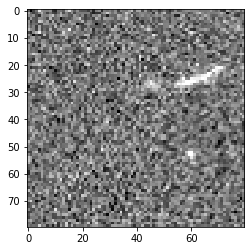

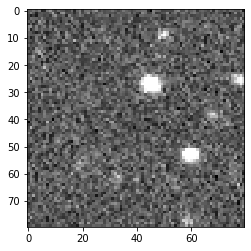

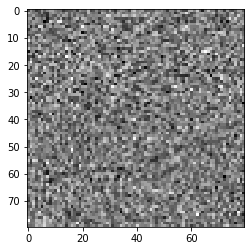

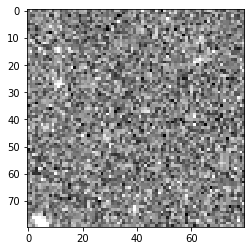

In [117]:
%%time
sci_file, ref_file = random.choice(real_filename_pairs)
images = process_images(sci_file, ref_file)
print(len(images))

In [118]:
%%time
sci_file, ref_file = random.choice(filename_pairs)
images = process_images(sci_file, ref_file)
print(len(images))

KeyboardInterrupt: 

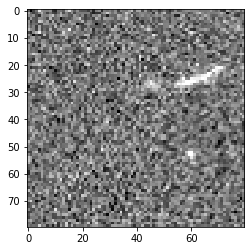

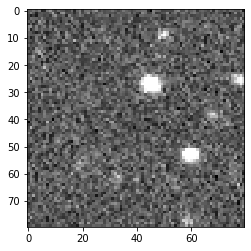

In [119]:
plt.imshow(images[0][0], cmap="gray")
plt.figure()
plt.imshow(images[0][1], cmap="gray")

In [120]:
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a", model)
result = analyzer.analyze(np.transpose(images, (0, 2, 3, 1)))

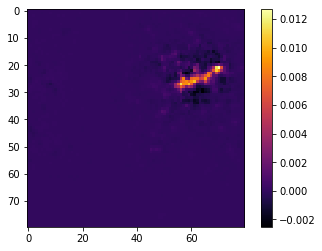

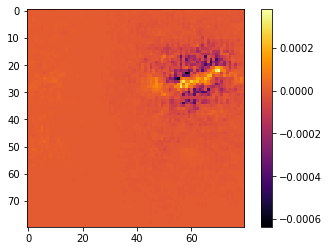

In [121]:
plt.imshow(result[0][..., 0], cmap="inferno")
plt.colorbar()
plt.figure()
plt.imshow(result[0][..., 1], cmap="inferno")
plt.colorbar()

In [55]:
res = result[0][..., 0]

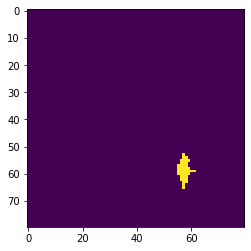

In [62]:
plt.imshow(res > res.std() * 5)

In [135]:
images

array([], shape=(0, 2, 80, 80), dtype=float64)

In [124]:
%%time
sci_file, ref_file = filename_pairs[2]
sci, ref = swarp_align(sci_file, ref_file)

CPU times: user 14.4 ms, sys: 40.2 ms, total: 54.6 ms
Wall time: 2.97 s


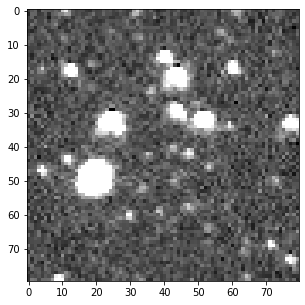

In [121]:
plt.figure(figsize=(5, 5))
plt.imshow(normalize(sci[420:500, 420:500]), cmap="gray")

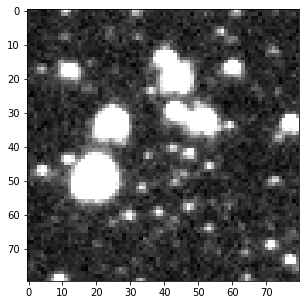

In [122]:
plt.figure(figsize=(5, 5))
plt.imshow(normalize(ref[420:500, 420:500]), cmap="gray")

In [28]:
!pwd

/home/fwang/Pipeline


In [75]:
with open("/home/fwang/savedlinks.pkl", "rb") as f:
    pkl.load(f)

EOFError: Ran out of input

In [1]:
import tables

In [2]:
fileh = tables.open_file('/media/rd1/ztf_neos/training_examples/batches/hard_negative_cases.h5', mode='r')

In [3]:
import matplotlib.pyplot as plt

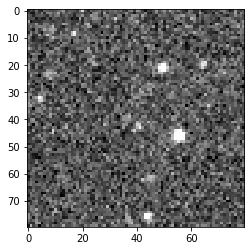

In [31]:
plt.imshow(fileh.root.hard_images[70][..., 1], cmap="gray")